In [1]:
# get relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths
from uncertainties import ufloat, umath

In [2]:
# fancy plotting
import scienceplots
plt.style.use(['science', 'notebook', 'grid', 'high-contrast'])

## Task 1: Zählrohrcharakteristik

In [3]:
task1_raw = pd.read_csv("Task1_raw.csv", delimiter=';')
task1_raw.head()

,V,Counts
0,312,12
1,312,8
2,312,10
3,312,12
4,312,2


In [16]:
voltage = np.array(task1_raw['V'])
voltage_e = np.ones(len(voltage)) # min. incrementation is 1V
counts_n = np.array(task1_raw['Counts'])
counts_e = np.sqrt(np.array(task1_raw['Counts'])) # errors from Poission distribution

In [5]:
# get indices for fitting
indices_fit = np.where(voltage > 330)

In [6]:
# fitting
def constant_function(x, c):
    return c
popt, pvar = curve_fit(constant_function, voltage[indices_fit], counts_n[indices_fit], sigma=counts_e[indices_fit], absolute_sigma=True)
print("constant: ", popt[0], "+/-", np.sqrt(pvar[0][0]))

constant:  653.5919239142946 +/- 3.811071355129584


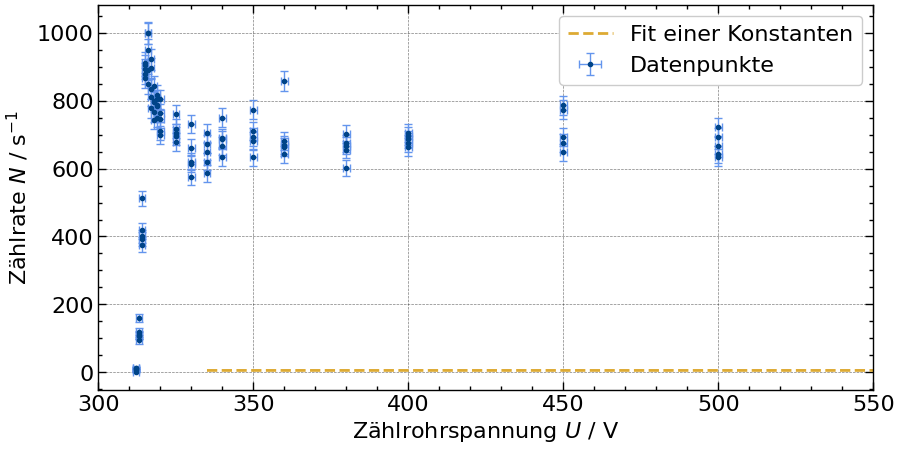

In [336]:
# final plot with fit
plt.figure(figsize=(10,5))
#data
plt.errorbar(voltage, counts_n, yerr=counts_e, xerr=voltage_e, fmt='.', ecolor='cornflowerblue', elinewidth=1, capsize=3, label="Datenpunkte")

#fits; error is so small of the fit, that plotting it is unnecessary 
voltage_fit = np.arange(voltage[indices_fit].min(), voltage[indices_fit].max()+10, 0.1)
constant = np.ones(len(voltage_fit))*popt[0]
#constant_l = np.ones(len(voltage_fit))*(popt[0] - np.sqrt(pvar[0][0]))
#constant_u = np.ones(len(voltage_fit))*(popt[0] + np.sqrt(pvar[0][0]))
plt.plot(voltage_fit, constant,  '--', label="Fit einer Konstanten")

#plt.fill_between(voltage_fit, constant_u, constant_l, facecolor="gray", alpha=0.15)

plt.xlabel("Zählrohrspannung $U$ / V")
plt.ylabel(r"Zählrate $N$ / s$^{-1}$")
plt.xlim(300,550)
plt.legend()
#plt.savefig("plots/zaehlrohrcharakteristik_mitfit.png", dpi=400)
plt.show()

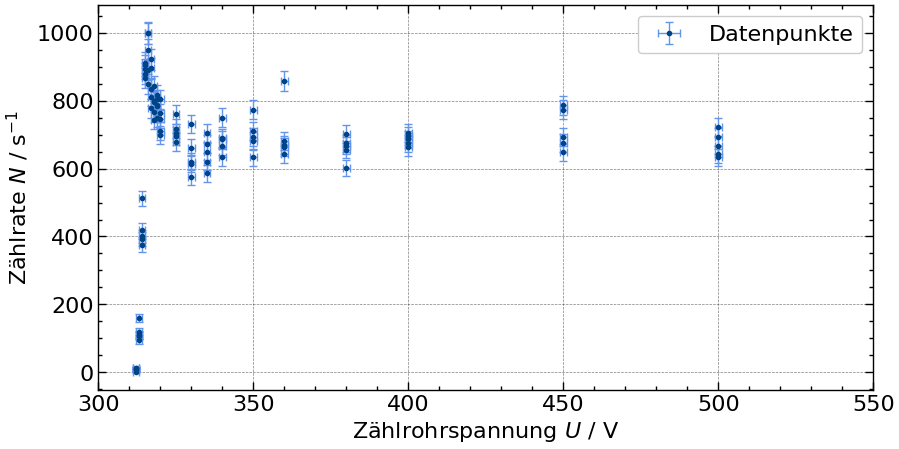

In [14]:
# final plot without fit
plt.figure(figsize=(10,5))
#data
plt.errorbar(voltage, counts_n, yerr=counts_e, xerr=voltage_e, fmt='.', ecolor='cornflowerblue', elinewidth=1, capsize=3, label="Datenpunkte") 

plt.xlabel("Zählrohrspannung $U$ / V")
plt.ylabel(r"Zählrate $N$ / s$^{-1}$")
plt.xlim(300,550)
plt.legend()
plt.savefig("plots/zaehlrohrcharakteristik.png", dpi=400)
plt.show()

## Task 2: Charakteristische Röntgenstrahlung

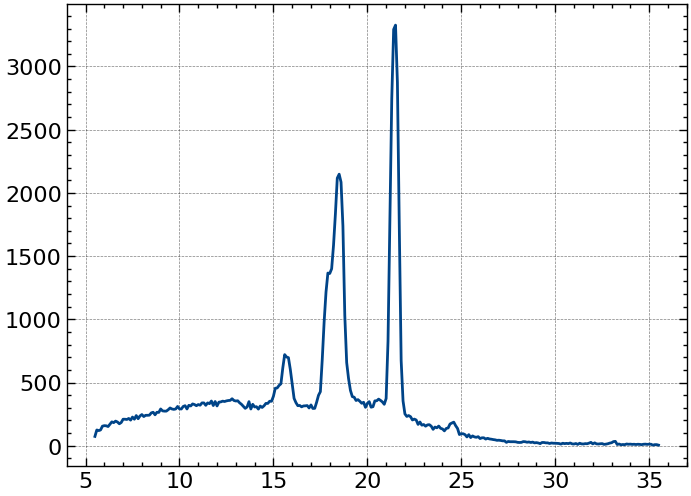

In [17]:
# reading in data and checking with plot
task2_raw = pd.read_csv("messung_1.csv", delimiter="\t" , names=['Xray_angle', 'Counts'], skiprows=2)
crystal_angle_task2 = np.array(task2_raw["Xray_angle"])
crystal_angle_task2_error = np.ones(len(crystal_angle_task2)) * 0.1 # error in measuring degrees
# note that counts are Poisson-distributed but we do not need it
counts_task2 = np.array(task2_raw["Counts"])

plt.plot(crystal_angle_task2, counts_task2)

In [18]:
# get wavenumbers here from the angle via bragg relation

# calculate distance
m_LiF = 25.939*1.66054e-27 # convert to kg
density_LiF = 2.63905 * 1e3 # in kg/m3
d = (m_LiF/(2*density_LiF))**(1/3)
d #m

# use bragg for determining lambda
angle_task2 = np.array([ufloat(crystal_angle_task2[i]*np.pi/180, crystal_angle_task2_error[i]*np.pi/180) for i in range(len(crystal_angle_task2))])# ufloat to incorporate errors in the angle measurement
wavelength_task2 = np.array([2*d*umath.sin(angle_task2[i]) for i in range(len(angle_task2))]) # use uncertainties for error propegation of angle
wavelength_task2_n = np.array([wavelength_task2[i].n for i in range(len(wavelength_task2))])
wavelength_task2_s = np.array([wavelength_task2[i].s for i in range(len(wavelength_task2))])

In [32]:
# find peak positions with nominal values and determine error of peak picking
# then combine both errors for our desired three lambda values
peaks, properties = find_peaks(counts_task2, prominence=100)
results_half = peak_widths(counts_task2, peaks, rel_height=0.5)
print(peaks)
print(results_half)

[101 130 160]
(array([5.69192547, 9.65649718, 5.15007802]), array([ 508. , 1226. , 1700.5]), array([ 99.14285714, 123.06666667, 156.88422649]), array([104.83478261, 132.72316384, 162.03430451]))


https://de.wikipedia.org/wiki/Halbwertsbreite says that the FWHM has following relation to sigma (= the error):
\begin{equation*}
    {\displaystyle \mathrm {FWHM} =2{\sqrt {2\ln 2}}\,\sigma \approx 2{,}3548\cdot \sigma }
\end{equation*}

In [42]:
# get the lambda errors
peak1_error = max(wavelength_task2_n[peaks[0]] - wavelength_task2_n[peaks[0]-6], wavelength_task2_n[peaks[0]] - wavelength_task2_n[peaks[0]+6])
peak2_error = max(wavelength_task2_n[peaks[1]] - wavelength_task2_n[peaks[1]-10], wavelength_task2_n[peaks[1]] - wavelength_task2_n[peaks[1]+10])
peak3_error = max(wavelength_task2_n[peaks[2]] - wavelength_task2_n[peaks[2]-5], wavelength_task2_n[peaks[2]] - wavelength_task2_n[peaks[2]+5])
tot_peak_error = np.array([peak1_error, peak2_error, peak3_error]) / (2*np.sqrt(2*np.log(2)))
tot_peak_error

array([1.72717089e-12, 2.83830310e-12, 1.39074070e-12])

<ErrorbarContainer object of 3 artists>

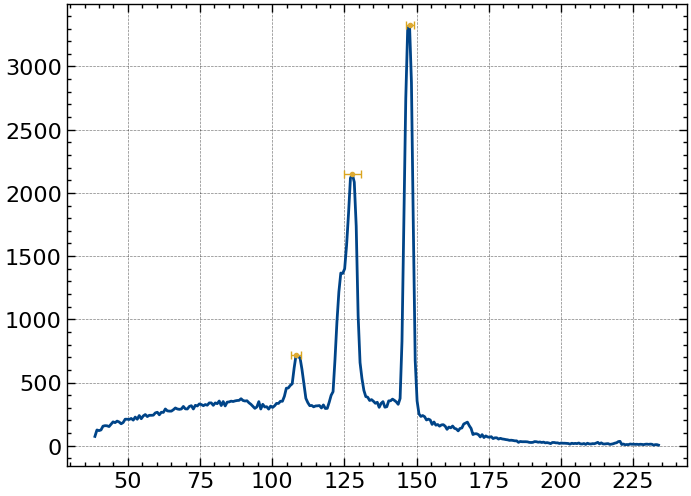

In [43]:
# plotting with transformed axis + plot peaks with their uncertainties
plt.plot(np.array([wavelength_task2[i].n for i in range(len(wavelength_task2))])*1e12, counts_task2)
#plot in peak positions
plt.errorbar(wavelength_task2_n[peaks]*1e12, counts_task2[peaks], xerr=tot_peak_error*1e12, ecolor='goldenrod', fmt=".", elinewidth=1, capsize=3)


In [44]:
# apply gaussian error propagation to  determine the final errors of the lambdas and plot - take this for protocol

peak1_error_final = np.sqrt(tot_peak_error[0]**2 + wavelength_task2_s[peaks[0]]**2)
peak2_error_final = np.sqrt(tot_peak_error[1]**2 + wavelength_task2_s[peaks[1]]**2)
peak3_error_final = np.sqrt(tot_peak_error[2]**2 + wavelength_task2_s[peaks[2]]**2)
tot_peak_error_fin = np.array([peak1_error_final, peak2_error_final, peak3_error_final])
tot_peak_error_fin

array([1.85507234e-12, 2.91549819e-12, 1.53678559e-12])

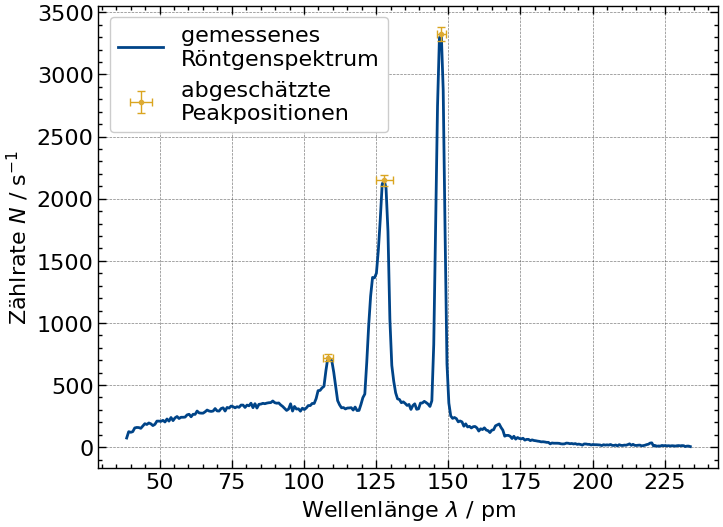

In [280]:
plt.plot(np.array([wavelength_task2[i].n for i in range(len(wavelength_task2))])*1e12, counts_task2, label="gemessenes \nRöntgenspektrum")
#plot in peak positions
plt.errorbar(wavelength_task2_n[peaks]*1e12, counts_task2[peaks], xerr=tot_peak_error_fin*1e12, yerr=np.sqrt(counts_task2[peaks]), ecolor='goldenrod', fmt="." , elinewidth=1, capsize=3, label="abgeschätzte \nPeakpositionen")
plt.xlabel("Wellenlänge $\lambda$ / pm")
plt.ylabel(r"Zählrate $N$ / s$^{-1}$")
plt.legend()
#plt.savefig("plots/charakteristischeRoentgen.png", dpi=400)
plt.show()

In [49]:
# determine finally transition energies
from scipy.constants import h,c, e
transition_energies = np.array([h*c/(ufloat(wavelength_task2_n[peaks[i]], tot_peak_error_fin[i])) for i in range(len(peaks))])
transition_energies # in J
print("transition energies in eV are given as:", transition_energies/e)

transition energies in eV are given as: [11449.992737984488+/-196.15750764441086
 9704.017671943215+/-221.4366969665024
 8401.417972500207+/-87.48873219435097]


$\textbf{important:}$

closing remark: there are in my opinion also some neighboured transitions but essentially these 3 are the characteristic ones which we can also determine automatically and they give us already enough fingerprinting for illustrating that is is Wolfram

## Task 3: Bestimmung des Planckschen Wirkungsquantums

look when we are above the maximum
error comes from step size + error propage with uncertainty of angle

In [312]:
# get anode voltage from data book; errors are 100 V again, smallest increment
U_A = np.array([ufloat(20,0.1),ufloat(19,0.1),ufloat(16,0.1),ufloat(12,0.1),ufloat(8,0.1)]) #kV
inv_U_A = 1/U_A
inv_U_A_V = 1/(U_A*1000) # in V-1
inv_U_A_V

array([5e-05+/-2.5000000000000004e-07,
       5.2631578947368424e-05+/-2.770083102493075e-07,
       6.25e-05+/-3.90625e-07,
       8.333333333333333e-05+/-6.944444444444445e-07,
       0.000125+/-1.5625e-06], dtype=object)

In [51]:
# as before transform to wavelength, do this for all 5 measurements
task3_raw = []
crystal_angle_task3 = []
crystal_angle_task3_error = []
counts_task3 = []
counts_task3_error = []
angle_task3 = []
wavelength_task3 = []
wavelength_task3_n = []
wavelength_task3_s = []
for i in range(2,7):
    task3_raw.append(pd.read_csv(f'messung_{i}.csv', delimiter="\t" , names=['Xray_angle', 'Counts'], skiprows=2))
    crystal_angle_task3.append(task3_raw[i-2]["Xray_angle"])
    crystal_angle_task3_error.append(np.ones(len(crystal_angle_task3[i-2])) * 0.1)
    counts_task3.append(np.array(task3_raw[i-2]["Counts"]))
    counts_task3_error.append(np.array(np.sqrt(task3_raw[i-2]["Counts"])))
    
    # use bragg for determining lambda
    angle_task3.append(np.array([ufloat(crystal_angle_task3[i-2][j]*np.pi/180, crystal_angle_task3_error[i-2][j]*np.pi/180) for j in range(len(crystal_angle_task3[i-2]))]))# ufloat to incorporate errors in the angle measurement
    wavelength_task3.append(np.array([2*d*umath.sin(angle_task3[i-2][j]) for j in range(len(angle_task3[i-2]))])) # use uncertainties for error propagation of angle
    wavelength_task3_n.append(np.array([wavelength_task3[i-2][j].n for j in range(len(wavelength_task3[i-2]))]))
    wavelength_task3_s.append(np.array([wavelength_task3[i-2][j].s for j in range(len(wavelength_task3[i-2]))]))

In [182]:
# determine minimal wavelength with linear fit

#def fit_function(x, a, b, c):
#    return a*(x-b) + c# b is the minimum wavelength

In [181]:
#from sklearn.metrics import r2_score - used tis for some tests
# do the fits her; manual optimization of fit range
#popt1, pcov1 = curve_fit(fit_function, np.array(wavelength_task3_n[0][30:74])*1e12, counts_task3[0][30:74], 
#                         p0=[3, 60, -4], sigma = counts_task3_error[0][30:74], absolute_sigma=True)
#popt2, pcov2 = curve_fit(fit_function, np.array(wavelength_task3_n[1][35:74])*1e12, counts_task3[1][35:74], 
#                         p0=[2, 70, -5], sigma = counts_task3_error[1][35:74], absolute_sigma=True)
#popt3, pcov3 = curve_fit(fit_function, np.array(wavelength_task3_n[2][57:74])*1e12, counts_task3[2][57:74], 
#                         p0=[2, 76, -6], sigma = counts_task3_error[2][57:74], absolute_sigma=True)
#popt4, pcov4 = curve_fit(fit_function, np.array(wavelength_task3_n[3][90:115])*1e12, counts_task3[3][90:115], 
#                         p0=[4, 10, -100], sigma = counts_task3_error[3][90:115], absolute_sigma=True)
#popt5, pcov5 = curve_fit(fit_function, np.array(wavelength_task3_n[4][164:])*1e12, counts_task3[4][164:], 
#                         p0=[4, 10, -100], sigma = counts_task3_error[4][164:], absolute_sigma=True)
#popt5

In [272]:
# get indices of best guess
index_lambda1 = np.where(counts_task3[0] > 5)[0][0]
index_lambda2 = np.where(counts_task3[1] > 5)[0][0]
index_lambda3 = np.where(counts_task3[2] > 3)[0][0]
index_lambda4 = np.where(counts_task3[3] > 1)[0][0]
index_lambda5 = np.where(counts_task3[4] > 1)[0][0]

In [275]:
# determine the lambda min values from when we are above the maximal value in the first data points
lambda_min1 = wavelength_task3_n[0][index_lambda1]
lambda_min2 = wavelength_task3_n[1][index_lambda2]
lambda_min3 = wavelength_task3_n[2][index_lambda3]
lambda_min4 = wavelength_task3_n[3][index_lambda4]
lambda_min5 = wavelength_task3_n[4][index_lambda5]

# error is determined from the step size AND the uncertainty of each lambda (= error propagation) - these are two distinct errors
# one comes from that the actual value of lambda is uncertain and one that we do not know the values in between
max_dev1 = max(wavelength_task3_n[0][index_lambda1] - wavelength_task3_n[0][index_lambda1-1],
              wavelength_task3_n[0][index_lambda1+1] - wavelength_task3_n[0][index_lambda1])
lambda_min1_err = np.sqrt(wavelength_task3_s[0][index_lambda1]**2 + max_dev1**2)

max_dev2 = max(wavelength_task3_n[1][index_lambda2] - wavelength_task3_n[1][index_lambda2-1],
              wavelength_task3_n[1][index_lambda2+1] - wavelength_task3_n[1][index_lambda2])
lambda_min2_err = np.sqrt(wavelength_task3_s[1][index_lambda2]**2 + max_dev2**2)

max_dev3 = max(wavelength_task3_n[2][index_lambda3] - wavelength_task3_n[2][index_lambda3-1],
              wavelength_task3_n[2][index_lambda3+1] - wavelength_task3_n[2][index_lambda3])
lambda_min3_err = np.sqrt(wavelength_task3_s[2][index_lambda3]**2 + max_dev3**2)

max_dev4 = max(wavelength_task3_n[3][index_lambda4] - wavelength_task3_n[3][index_lambda4-1],
              wavelength_task3_n[3][index_lambda4+1] - wavelength_task3_n[3][index_lambda4])
lambda_min4_err = np.sqrt(wavelength_task3_s[3][index_lambda4]**2 + max_dev4**2)

max_dev5 = max(wavelength_task3_n[4][index_lambda4] - wavelength_task3_n[4][index_lambda4-1],
              wavelength_task3_n[4][index_lambda4+1] - wavelength_task3_n[4][index_lambda4])
lambda_min5_err = np.sqrt(wavelength_task3_s[4][index_lambda4]**2 + max_dev5**2)


In [276]:
# collect lambda_min values
lambda_min = np.array([lambda_min1, lambda_min2, lambda_min3, lambda_min4, lambda_min5])
lambda_min_err = np.array([lambda_min1_err, lambda_min2_err, lambda_min3_err, lambda_min4_err, lambda_min5_err])

# determine the sin theta values
sintheta_min = lambda_min/(2*d)
sintheta_min_err = lambda_min_err/(2*d)

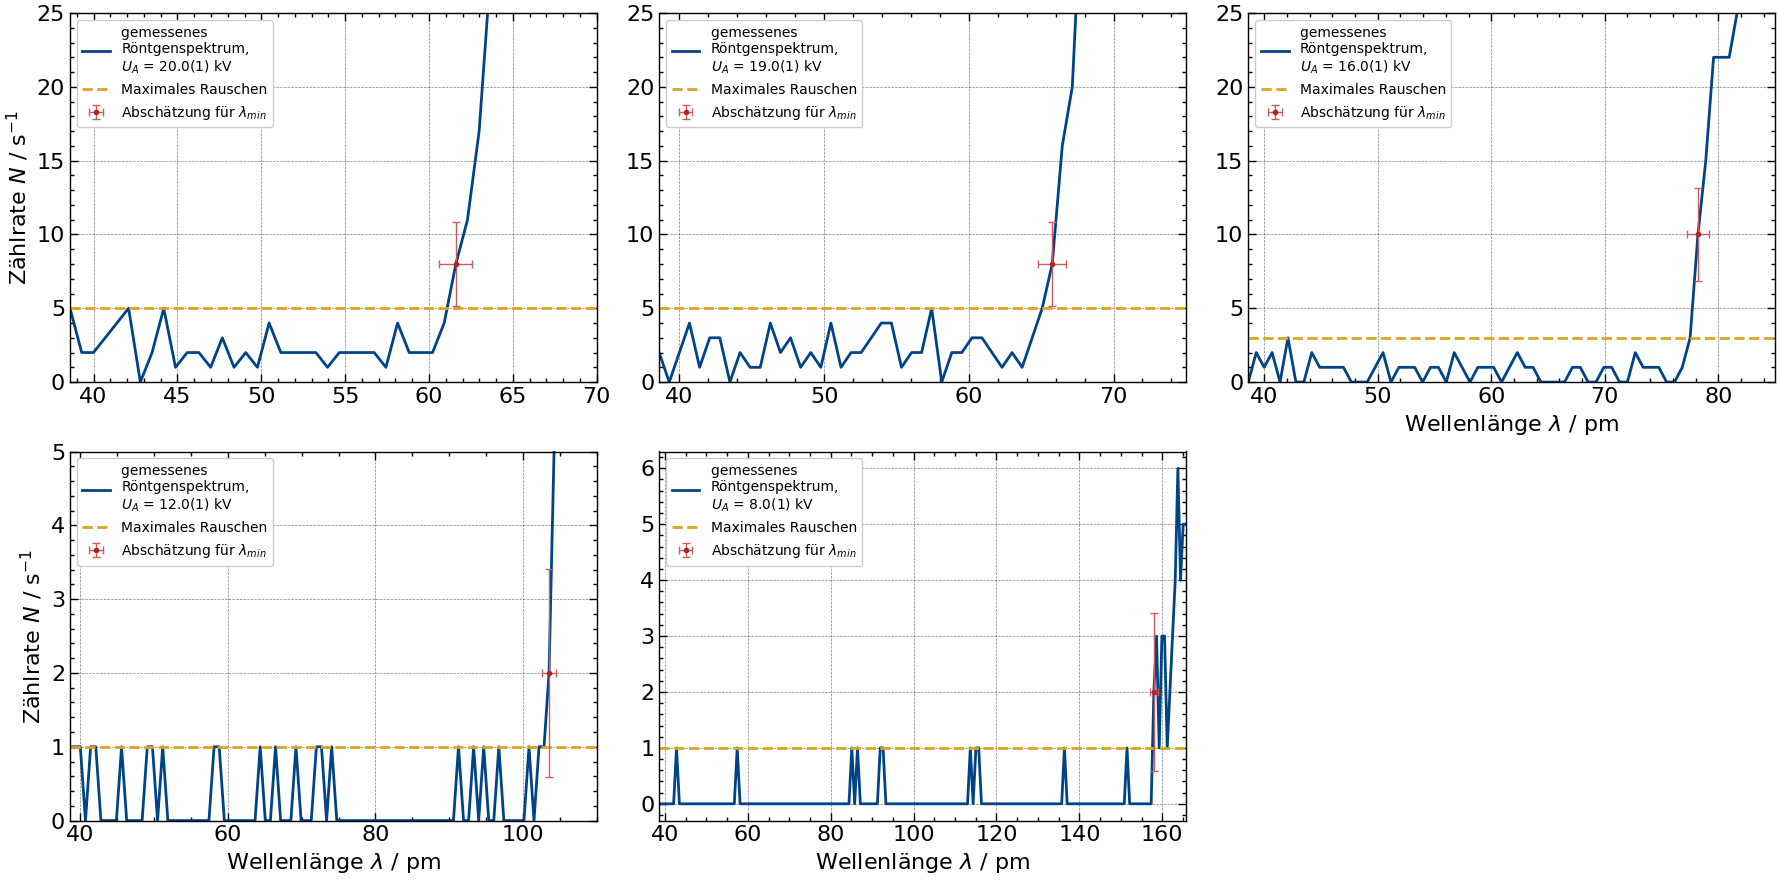

In [307]:
# plot everything in the important region, mark the maximal N in a region + the estimated lambda_min 
fig,axs = plt.subplots(2,3, figsize=(18,9))
lower_xbound = 2*d*np.sin(5.5*np.pi/180)*1e12 # from here on we start measuring

axs[0, 0].plot(np.array([wavelength_task3[0][j].n for j in range(len(wavelength_task3[0]))])*1e12, 
               counts_task3[0], label="gemessenes \nRöntgenspektrum,\n" f'$U_A$ = 20.0(1) kV')
axs[0, 0].hlines(5, lower_xbound, 70, linestyles='dashed', colors='goldenrod', label='Maximales Rauschen')
axs[0, 0].errorbar(lambda_min[0]*1e12, 
                   counts_task3[0][index_lambda1], color="firebrick", xerr=lambda_min_err[0]*1e12, yerr=np.sqrt(counts_task3[0][index_lambda1]), 
                   ecolor='indianred', fmt="." , elinewidth=1, capsize=3, label="Abschätzung für $\lambda_{min}$")
axs[0, 0].legend(loc='upper left',prop={'size': 10})
axs[0, 0].set_xlim(lower_xbound,70)
axs[0, 0].set_ylim(0,25)
axs[0, 0].set_ylabel(r"Zählrate $N$ / s$^{-1}$")

axs[0, 1].plot(np.array([wavelength_task3[1][j].n for j in range(len(wavelength_task3[1]))])*1e12, 
               counts_task3[1], label="gemessenes \nRöntgenspektrum,\n" f'$U_A$ = 19.0(1) kV')
axs[0, 1].hlines(5, lower_xbound, 75, linestyles='dashed', colors='goldenrod', label='Maximales Rauschen')
axs[0, 1].errorbar(lambda_min[1]*1e12, 
                   counts_task3[1][index_lambda2], color="firebrick", xerr=lambda_min_err[1]*1e12, yerr=np.sqrt(counts_task3[1][index_lambda2]), 
                   ecolor='indianred', fmt="." , elinewidth=1, capsize=3, label="Abschätzung für $\lambda_{min}$")
axs[0, 1].legend(loc='upper left',prop={'size': 10})
axs[0, 1].set_xlim(lower_xbound,75)
axs[0, 1].set_ylim(0,25)

axs[0, 2].plot(np.array([wavelength_task3[2][j].n for j in range(len(wavelength_task3[2]))])*1e12, 
               counts_task3[2], label="gemessenes \nRöntgenspektrum,\n" f'$U_A$ = 16.0(1) kV')
axs[0, 2].hlines(3, lower_xbound, 85, linestyles='dashed', colors='goldenrod', label='Maximales Rauschen')
axs[0, 2].errorbar(lambda_min[2]*1e12, 
                   counts_task3[2][index_lambda3], color="firebrick", xerr=lambda_min_err[2]*1e12, yerr=np.sqrt(counts_task3[2][index_lambda3]), 
                   ecolor='indianred', fmt="." , elinewidth=1, capsize=3, label="Abschätzung für $\lambda_{min}$")
axs[0, 2].legend(loc='upper left',prop={'size': 10})
axs[0, 2].set_xlabel("Wellenlänge $\lambda$ / pm")
axs[0, 2].set_xlim(lower_xbound,85)
axs[0, 2].set_ylim(0,25)

axs[1, 0].plot(np.array([wavelength_task3[3][j].n for j in range(len(wavelength_task3[3]))])*1e12, 
               counts_task3[3], label="gemessenes \nRöntgenspektrum,\n" f'$U_A$ = 12.0(1) kV')
axs[1, 0].hlines(1, lower_xbound, 110, linestyles='dashed', colors='goldenrod', label='Maximales Rauschen')
axs[1, 0].errorbar(lambda_min[3]*1e12, 
                   counts_task3[3][index_lambda4], color="firebrick", xerr=lambda_min_err[3]*1e12, yerr=np.sqrt(counts_task3[3][index_lambda4]), 
                   ecolor='indianred', fmt="." , elinewidth=1, capsize=3, label="Abschätzung für $\lambda_{min}$")
axs[1, 0].legend(prop={'size': 10})
axs[1, 0].set_ylabel(r"Zählrate $N$ / s$^{-1}$")
axs[1, 0].set_xlabel("Wellenlänge $\lambda$ / pm")
axs[1, 0].set_xlim(lower_xbound,110)
axs[1, 0].set_ylim(0,5)

axs[1, 1].plot(np.array([wavelength_task3[4][j].n for j in range(len(wavelength_task3[4]))])*1e12, 
               counts_task3[4], label="gemessenes \nRöntgenspektrum,\n" f'$U_A$ = 8.0(1) kV')
axs[1, 1].hlines(1, lower_xbound, max(np.array([wavelength_task3[4][j].n for j in range(len(wavelength_task3[4]))])*1e12), linestyles='dashed', colors='goldenrod', label='Maximales Rauschen')
axs[1, 1].set_xlim(lower_xbound,max(np.array([wavelength_task3[4][j].n for j in range(len(wavelength_task3[4]))])*1e12))
axs[1, 1].errorbar(lambda_min[4]*1e12, 
                   counts_task3[4][index_lambda5], color="firebrick", xerr=lambda_min_err[4]*1e12, yerr=np.sqrt(counts_task3[4][index_lambda5]), 
                   ecolor='indianred', fmt="." , elinewidth=1, capsize=3, label="Abschätzung für $\lambda_{min}$")
axs[1, 1].legend(prop={'size': 10})
axs[1, 1].set_xlabel("Wellenlänge $\lambda$ / pm")
fig.delaxes(axs[1, 2])
plt.tight_layout()
#plt.savefig("plots/all_measurements_with_chosen_lambda_min_mityerror.png", dpi=400)
plt.show()

In [308]:
def linear_fit(x,a,d):
    return a*x + d

In [416]:
# final results from fit for both parameters
popt1, pcov1 = curve_fit(linear_fit, np.array([inv_U_A_V[i].n for i in range(len(inv_U_A_V))]), 
                         lambda_min, sigma=lambda_min_err, absolute_sigma=True)

popt2, pcov2 = curve_fit(linear_fit, np.array([inv_U_A_V[i].n for i in range(len(inv_U_A_V))]), 
                         sintheta_min, sigma=sintheta_min_err, absolute_sigma=True)

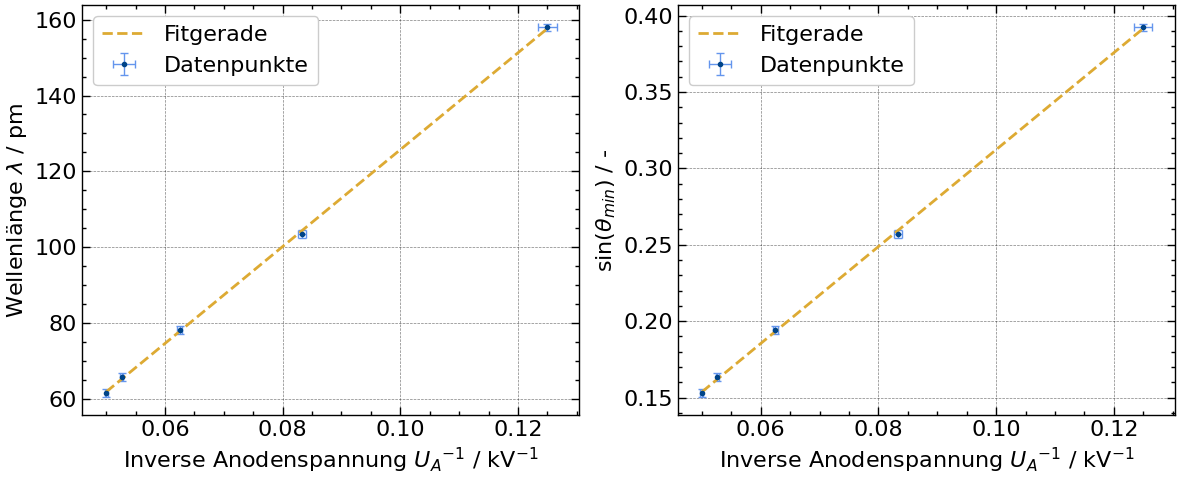

In [415]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
# plotting data points
axs[0].errorbar(np.array([inv_U_A[i].n for i in range(len(inv_U_A))]), lambda_min*1e12, fmt='.', 
             xerr=np.array([inv_U_A[i].s for i in range(len(inv_U_A))]), yerr=lambda_min_err*1e12, ecolor='cornflowerblue',
             elinewidth=1, capsize=3, label="Datenpunkte")
axs[1].errorbar(np.array([inv_U_A[i].n for i in range(len(inv_U_A))]), sintheta_min, fmt='.', 
             xerr=np.array([inv_U_A[i].s for i in range(len(inv_U_A))]), yerr=sintheta_min_err, ecolor='cornflowerblue',
             elinewidth=1, capsize=3, label="Datenpunkte")

# plotting both fit results
axs[0].plot(np.array([inv_U_A[i].n for i in range(len(inv_U_A))]), 
         (popt1[0]*np.array([inv_U_A_V[i].n for i in range(len(inv_U_A_V))]) + popt1[1])*1e12, '--',
         label="Fitgerade")
axs[1].plot(np.array([inv_U_A[i].n for i in range(len(inv_U_A))]), 
         popt2[0]*np.array([inv_U_A_V[i].n for i in range(len(inv_U_A_V))]) + popt2[1], '--',
         label="Fitgerade")

axs[0].set_ylabel("Wellenlänge $\lambda$ / pm")
axs[0].set_xlabel(r"Inverse Anodenspannung $U_A$$^{-1}$ / kV$^{-1}$")
axs[0].legend()

axs[1].set_ylabel(r"sin($\theta_{min}$) / -")
axs[1].set_xlabel(r"Inverse Anodenspannung $U_A$$^{-1}$ / kV$^{-1}$")
axs[1].legend()

plt.tight_layout()
#plt.savefig("plots/planck_fit.png", dpi=400)
plt.show()

In [411]:
# evaluating both fit results
a1 = ufloat(popt1[0], np.sqrt((pcov1[0][0])))
d1 = ufloat(popt1[1], np.sqrt((pcov1[1][1])))
print("fit parameters a = ", a1, ", d = ", d1)
h_fit1 = a1*e/c
print("h (fit 1) = ", h_fit1, " Js")

a2 = ufloat(popt2[0], np.sqrt((pcov2[0][0])))
d2 = ufloat(popt2[1], np.sqrt((pcov2[1][1])))
print("fit parameters a = ", a2, ", d = ", d2)
h_fit2 = a2*e/c * (2*d)
print("h (fit 2) = ", h_fit2, " Js")

fit parameters a =  (1.277+/-0.016)e-06 , d =  (-2.0+/-1.2)e-12
h (fit 1) =  (6.82+/-0.08)e-34  Js
fit parameters a =  (3.17+/-0.04)e+03 , d =  -0.0049+/-0.0031
h (fit 2) =  (6.82+/-0.08)e-34  Js


In [412]:
# see if we have good results
print(abs(h - h_fit1.n) < h_fit1.s)
print(abs(h - h_fit2.n) < h_fit2.s)

False
False


:(

Alternative:

In [413]:
lambda_min_full = np.array([ufloat(lambda_min[i], lambda_min_err[i]) for i in range(len(lambda_min))])
h_single_measurements = lambda_min_full*np.array([U_A[i].n for i in range(len(U_A))])*1000*e/c
h_single_measurements

array([6.584294170309513e-34+/-1.0498733561244077e-35,
       6.677852648388675e-34+/-9.957127977907324e-36,
       6.687657563473133e-34+/-8.337328594433752e-36,
       6.639979198416212e-34+/-6.160246619064197e-36,
       6.754253994736376e-34+/-4.106831079376131e-36], dtype=object)

In [414]:
# average
h_avg = sum(h_single_measurements)/len(h_single_measurements)
h_avg

6.668807515064781e-34+/-3.653456182697156e-36

In [409]:
#test average
print(abs(h_avg - h_avg.n) < h_avg.s)

True


$\textbf{important:}$

(1) Kramer's law would not be properly doable for the lower fits; still try maybe or at least discuss it; but it is not used in the script

(2) linear fits result in too high variances, as we have too few points to fit

# plot everything
fig,axs = plt.subplots(2,3, figsize=(18,9))

axs[0, 0].plot(np.array([wavelength_task3[0][j].n for j in range(len(wavelength_task3[0]))])*1e12, counts_task3[0], label="gemessenes \nRöntgenspektrum,\n" f'$U_A$ = 20.0(1) kV')
axs[0, 0].plot(np.array(wavelength_task3_n[0][30:74])*1e12, 
               fit_function(np.array(wavelength_task3_n[0][30:74])*1e12, popt1[0], popt1[1], popt1[2]), "--", 
               label = 'Fitgerade, $\lambda_{min}$ = ' f'{popt1[1]:.2f} $\pm$')
axs[0, 0].legend(loc='upper left',prop={'size': 10})
axs[0, 0].set_xlim(40,100)
axs[0, 0].set_ylim(0,200)
axs[0, 0].set_ylabel(r"Zählrate $N$ / s$^{-1}$")
axs[0, 1].plot(np.array([wavelength_task3[1][j].n for j in range(len(wavelength_task3[1]))])*1e12, counts_task3[1], label="gemessenes \nRöntgenspektrum,\n" f'$U_A$ = 19.0(1) kV')
axs[0, 1].plot(np.array(wavelength_task3_n[1][35:74])*1e12, 
               fit_function(np.array(wavelength_task3_n[1][35:74])*1e12, popt2[0], popt2[1], popt2[2]), "--", 
               label = 'Fitgerade,  $\lambda_{min}$ = ' f'{popt2[1]:.2f} $\pm$')
axs[0, 1].legend(loc='upper left',prop={'size': 10})
axs[0, 1].set_xlim(50,100)
axs[0, 1].set_ylim(0,200)
axs[0, 2].plot(np.array([wavelength_task3[2][j].n for j in range(len(wavelength_task3[2]))])*1e12, counts_task3[2], label="gemessenes \nRöntgenspektrum,\n" f'$U_A$ = 16.0(1) kV')
axs[0, 2].plot(np.array(wavelength_task3_n[2][57:74])*1e12, 
               fit_function(np.array(wavelength_task3_n[2][57:74])*1e12, popt3[0], popt3[1], popt3[2]), "--", 
               label = 'Fitgerade,  $\lambda_{min}$ = ' f'{popt3[1]:.2f} $\pm$')
axs[0, 2].legend(loc='upper left',prop={'size': 10})
axs[0, 2].set_xlabel("Wellenlänge $\lambda$ / pm")
axs[0, 2].set_xlim(50,100)
axs[0, 2].set_ylim(0,150)
axs[1, 0].plot(np.array([wavelength_task3[3][j].n for j in range(len(wavelength_task3[3]))])*1e12, counts_task3[3], label="gemessenes \nRöntgenspektrum,\n" f'$U_A$ = 12.0(1) kV')
axs[1, 0].plot(np.array(wavelength_task3_n[3][90:115])*1e12, 
               fit_function(np.array(wavelength_task3_n[3][90:115])*1e12, popt4[0], popt4[1], popt4[2]), "--", 
               label = 'Fitgerade,  $\lambda_{min}$ = ' f'{popt4[1]:.2f} $\pm$')
axs[1, 0].legend(prop={'size': 10})
axs[1, 0].set_ylabel(r"Zählrate $N$ / s$^{-1}$")
axs[1, 0].set_xlabel("Wellenlänge $\lambda$ / pm")
axs[1, 1].plot(np.array([wavelength_task3[4][j].n for j in range(len(wavelength_task3[4]))])*1e12, counts_task3[4], label="gemessenes \nRöntgenspektrum,\n" f'$U_A$ = 8.0(1) kV')
axs[1, 1].legend(prop={'size': 10})
axs[1, 1].set_xlabel("Wellenlänge $\lambda$ / pm")
fig.delaxes(axs[1, 2])
plt.tight_layout()
#plt.savefig("plots/all_measurements.png", dpi=400)
plt.show()